## Cross Currency Swap (XCS)

The goal of the project is to compute the par spreads of a set of cross currency swaps. 

A XCS is a derivative contract, between two counterparties, with payments benchmarked against two interest rate indexes denominated in two different currencies (commonly the 3-month tenor IBOR in the appropriate currency, for example LIBOR in USD, GBP, EURIBOR in EUR), and initial and final notionals are exchanged.

The par basis spread is the agreed amount chosen to be added (or reduced in the case of a negative spread) usually to the domestic leg.

The input parameters are:

* the market quotes of a set of Overnight Index Swaps;
* 2 sets of libor rates and their fixing dates (EURIBOR-3M, LIBOR-3M);
* currency exchange rates;
* the static data of XCSs (nominal, maturity...)

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When not possible develop your own classes.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import ForwardRateCurve

pricing_date = date.today()

surv_prob = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/survival_probabilities_proj3.csv")

ois_quotes = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx")
df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx", sheet_name="EURIBOR1M")
dates = [pricing_date + relativedelta(months=i) for i in df.loc[:, 'months']]
euribor_1m_curve = ForwardRateCurve(dates, df['rates']*0.01)

df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx", sheet_name="USDLIBOR3M")
dates = [pricing_date + relativedelta(months=i) for i in df.loc[:, 'months']]
libor_3m_curve = ForwardRateCurve(dates, df['rates']*0.01)

fx_rates = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/fx_rates.csv", index_col='currencies')

xcs_data = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/xcs_data.csv")
print (xcs_data.head())

   nominal_dom  nominal_for  maturity  tenor currencies
0   30000000.0   25000000.0         2      3     EURUSD
1    1500000.0    1500000.0         3      3     EURGBP
2   15000000.0   15000000.0         4      3     USDEUR
3    5500000.0    6500000.0         5      3     EURUSD
4   10000000.0   12000000.0         3      3     EURGBP


First of all we need to determine the discount curve from the OIS market quotes using the bootstrap technique.

* generate set of OIS according to the market quotes
* create an objective function with a discount curve and the squared sum of NPVs
* check minimization results
* create the found `DiscountCurve`

In [ ]:
from finmarkets import OvernightIndexSwap
pillar_dates = [pricing_date]

swaps = []
for q in range(len(ois_quotes)):
  swap = OvernightIndexSwap(1, pricing_date, 
                            ois_quotes.loc[q, 'quotes']*0.01,
                            ois_quotes.loc[q, 'months'])
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [ ]:
from finmarkets import DiscountCurve
import numpy as np

def objective_function(x):
  x = np.insert(x, 0, 1)
  curve = DiscountCurve(pillar_dates, x)
    
  sum_sq = 0.0
  for swap in swaps:
    sum_sq += swap.npv(curve) ** 2
        
  return sum_sq

In [ ]:
from scipy.optimize import minimize

x0 = [.5 for _ in range(len(swaps))]
bounds = [(0.01, 10.0) for i in range(len(x0))]

result = minimize(objective_function, x0, bounds=bounds)

In [ ]:
print (result)
print (objective_function(x0))
print (objective_function(result.x))

      fun: 1.5598529167700339e-12
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.64128952e-07,  4.09600189e-07,  5.43180470e-07,  6.57389554e-07,
        7.19364263e-07,  7.22492722e-07,  6.62523711e-07,  5.44799683e-07,
        3.78393784e-07,  1.74928116e-07, -6.08423241e-08, -4.86986405e-07,
       -2.10230582e-07, -1.26395171e-07, -1.52345542e-07, -1.68838077e-07,
       -1.84831190e-07, -1.92217060e-07, -1.98767741e-07, -2.05177692e-07,
       -2.11620647e-07, -2.18048021e-07, -2.28315276e-07, -4.78971431e-07,
       -9.37779333e-07, -1.32152115e-06, -1.07802350e-06, -4.81469865e-07,
        1.82215069e-07,  4.26642768e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 279
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.99945151, 0.99831221, 0.99696374, 0.99525709, 0.9934025 ,
       0.99136742, 0.98920052, 0.98696985, 0.98469232, 0.98239156,
       0.98001273, 0.97763556, 0.9638142 , 0.95044586

In [ ]:
dfs = np.insert(result.x, 0, 1)
dc = DiscountCurve(pillar_dates, dfs)

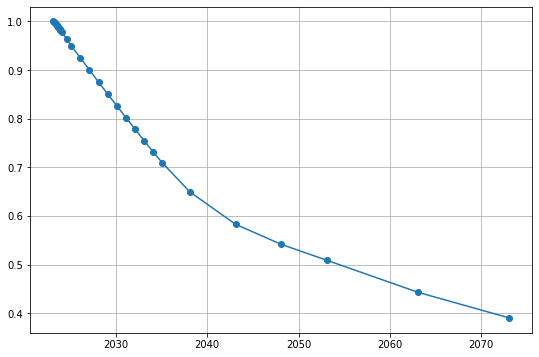

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(pillar_dates, dfs, marker='o')
plt.grid(True)
plt.show()

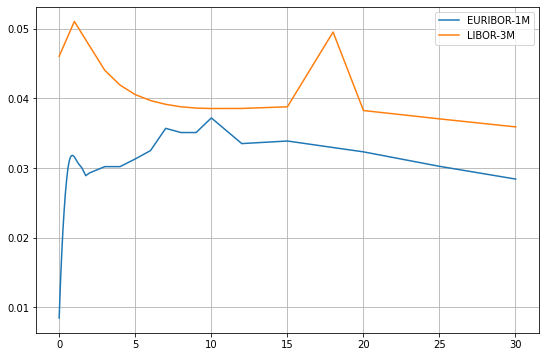

In [ ]:
plt.plot(euribor_1m_curve.pillar_dates, euribor_1m_curve.rates, label="EURIBOR-1M")
plt.plot(libor_3m_curve.pillar_dates, libor_3m_curve.rates, label='LIBOR-3M')
plt.legend()
plt.grid(True)
plt.show()

fc_curves = {"EURIBOR":euribor_1m_curve, "LIBOR":libor_3m_curve}

In [ ]:
forex = {}
for i, f in fx_rates.iterrows():
  forex.update({i:f['fx_rate']})
  inv = i[-3:] + i[:3]
  forex.update({inv:round(1/f['fx_rate'], 2)})

In [ ]:
from finmarkets import generate_dates

class CrossCurrencySwap:
  def __init__(self, amount_dom, amount_for, start_date, tenor, maturity, exchg_rate):
    self.amount_for = amount_for
    self.amount_dom = amount_dom
    self.exchg_rate = exchg_rate # for/dom
    self.payment_dates = generate_dates(start_date, maturity*12, tenor)

  def foreign_npv(self, dc, fc_for):
    b_f = 0
    for i in range(1, len(self.payment_dates)):
      tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/360
      F = fc_for.forward_rate(self.payment_dates[i-1], self.payment_dates[i])
      b_f += dc.df(self.payment_dates[i])*F*tau
      #print (b_f, F, tau, )
    b_f += dc.df(self.payment_dates[i]) - dc.df(self.payment_dates[0])
    #print (b_f)
    #print (b_f, self.amount_for, dc.df(self.payment_dates[i]))
    return b_f*self.amount_for

  def domestic_npv(self, dc, fc_dom, spread=0):
    b_d = 0
    for i in range(1, len(self.payment_dates)):
      tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/360
      F = fc_dom.forward_rate(self.payment_dates[i-1], self.payment_dates[i])+spread
      b_d += dc.df(self.payment_dates[i])*F*tau
      #print (F, tau, dc.df(self.payment_dates[i]))
      #print (b_d)
    b_d += dc.df(self.payment_dates[i]) - dc.df(self.payment_dates[0])
    #print (b_d, self.amount_dom)
    return b_d*self.amount_dom

  def value_dom_for_spread(self, spread, dc, fc_dom, fc_for):
    return self.foreign_npv(dc, fc_for)*self.exchg_rate - self.domestic_npv(dc, fc_dom, spread)

  def value_dom(self, dc, fc_dom, fc_for):
    #print (self.exchg_rate)
    return self.foreign_npv(dc, fc_for)*self.exchg_rate - self.domestic_npv(dc, fc_dom)

  def value_for(self, dc, fc_dom, fc_for):
    return self.domestic_npv(dc, fc_dom)/self.exchg_rate - self.foreign_npv(dc, fc_for) 

In [ ]:
fc_curves = {"EURIBOR":euribor_1m_curve, "LIBOR":libor_3m_curve}

xcss = []
xcs_curves = []
for i in range(len(xcs_data)):
  cur_dom = xcs_data.loc[i, 'currencies'][:3]
  cur_for = xcs_data.loc[i, 'currencies'][-3:]
  if cur_dom == "EUR" and not cur_for == "EUR":
    xcs_curves.append(("EURIBOR", "LIBOR"))
  elif not cur_dom == "EUR" and cur_for == "EUR":
    xcs_curves.append(("LIBOR", "EURIBOR"))
  elif not cur_dom == "EUR" and not cur_for == "EUR":    
    xcs_curves.append(("LIBOR", "LIBOR"))
    
  xcs = CrossCurrencySwap(xcs_data.loc[i, 'nominal_dom'], xcs_data.loc[i, 'nominal_for'],
                          pricing_date, xcs_data.loc[i, 'tenor'], 
                          xcs_data.loc[i, 'maturity'], 
                          1/forex[xcs_data.loc[i, 'currencies']])
  xcss.append(xcs)

In [ ]:
for i, xcs in enumerate(xcss):
  if i == 2:
    print (xcs.domestic_npv(dc, fc_curves[xcs_curves[i][0]]))
    print (xcs.foreign_npv(dc, fc_curves[xcs_curves[i][1]]))
    print (xcs.value_dom(dc, fc_curves[xcs_curves[i][0]], fc_curves[xcs_curves[i][1]]))

935849.6167225128
247856.27282445968
0.87
-720214.6593652328


In [ ]:
935849*1.15 -  247856

828370.3499999999

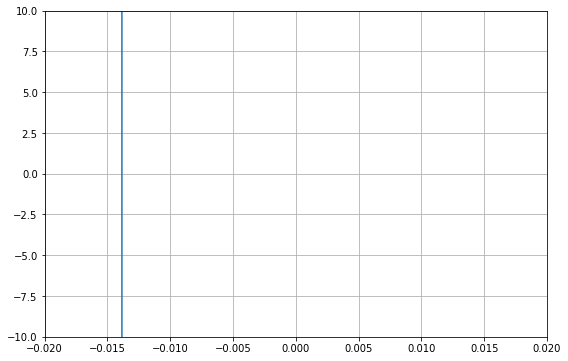

In [ ]:
plt.plot(np.arange(-1, 2, 0.1), xcss[4].value_dom_for_spread(np.arange(-1, 2, 0.1), dc, 
                                                             fc_curves[xcs_curves[4][0]], fc_curves[xcs_curves[4][1]]))
plt.grid(True)
plt.xlim(-0.02, 0.02)
plt.ylim(-10, 10)
plt.show()

In [ ]:
from scipy.optimize import brentq

for x in xcss:
    ps = brentq(x.value_dom_for_spread, -30 , 3, 
                args=(dc, fc_curves[xcs_curves[i][0]], fc_curves[xcs_curves[i][1]]))
    print (ps)

0.012060566836085584
0.01702024699939253
0.014343234201110722
0.009949573986847593
0.021352658261344803
